In [3]:
import torchaudio
import torch
import pandas as pd
import os 
import numpy as np
from scipy.signal import resample
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
class paddedData(Dataset):
    def __init__(self, 
                 annotations_file, 
                 audio_dir, 
                 transformation, 
                 target_sample_rate,
                 num_samples,
                 device):
        self.device = device
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
    
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label
    def _cut_if_necessary(self, signal):
        # signal -> tensor -> (1, num_samples) if we have more than needed, cut
        # (1, 50000) -> (1, 32000)
        print(signal.shape[1])
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        print(length_signal)
        if length_signal < self.num_samples:
            # if [1, 1, 1] right pad -> [1, 1, 1, 0, 0]
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples) # add num_missing_samples amount of 0's
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir,self.annotations.iloc[index, 0])
        path = path + '.wav'
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 3]

In [4]:
if __name__ == "__main__":
    ANNOTATIONS_FILE = "combined_annotations_Approach5.csv"
    AUDIO_DIR = "baby_audio_trimmed"
    SAMPLE_RATE = 8000
    # target sample rate, regardless of audio's sample rate
    NUM_SAMPLES = 60000
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=64,
    hop_length=40,
    n_mels=128
    )

dataset_class = paddedData(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device)
    
signal, label = dataset_class[2]
print(signal.shape, label)

/home/mohammed.alowais/.conda/envs/ugrip/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (33) may be set too low.
  warnings.warn(


54560
54560
torch.Size([1, 128, 1501]) 1


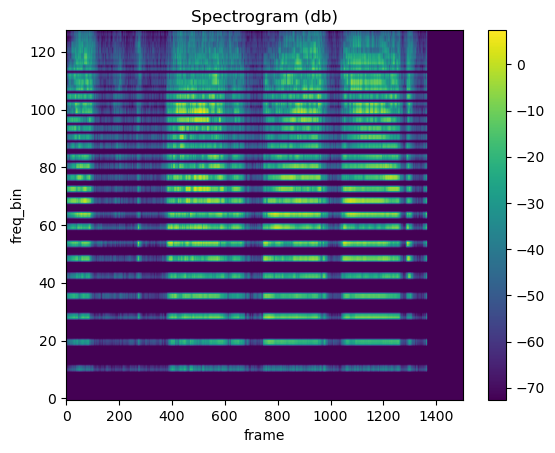

In [9]:
import librosa
import numpy as np

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
plot_spectrogram(signal.reshape(128, 1501).cpu())

